Vinculación a Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Librerías

In [ ]:
#Se importan las librerías necesarias
import pandas as pd
import numpy as np
import random
import unicodedata
import re

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import datetime
from datetime import date
import calendar

In [ ]:
import cufflinks as cf
pd.set_option("display.max_columns",200)
pd.set_option('display.max_rows', 200)
warnings.filterwarnings("ignore")

In [ ]:
from plotly.offline import plot,iplot
# pd.options.plotting.backend = "plotly"
import plotly.graph_objects as go
import plotly.express as px#graficos express


In [ ]:
from  functools import reduce
cf.go_offline()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import chisquare
from sklearn.impute import SimpleImputer

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

#Funciones

In [ ]:
#Se crea una función para verificar la completitud de las variables de la base.
def completitud(df):
    comple=pd.DataFrame(df.isnull().sum())
    comple.reset_index(inplace=True)
    comple=comple.rename(columns={"index":"columna",0:"total"})
    comple["completitud"]=(1-comple["total"]/df.shape[0])*100
    comple=comple.sort_values(by="completitud",ascending=True)
    comple.reset_index(drop=True,inplace=True)
    return comple

#Se crea una función en la cual se homologuen los simbolos de las variables de texto.
def clean_text(text, pattern="[^a-zA-Z0-9 ]"):
    cleaned_text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    cleaned_text = re.sub(pattern, " ", cleaned_text.decode("ascii"), flags=re.UNICODE)
    cleaned_text = u' '.join(cleaned_text.lower().strip().split())
    return cleaned_text
  
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

## Multicolinealidad Categoricas##
def multicolinealidad_cate(df,y,threshold=5,only_final_vif=False):
    '''
    Función para calcular el VIF Genralizado, (GVIF, Fox and Monette 1992)
    Las variables no deben de deben de estar transformadas con OneHotEncoder ya que la función lo realiza internamnete.
    Args:
        df
        y
        threshold
        only_final_vif
    
    Returns:
        pandas data frame: a data frame, indexed by factor of the GVIF, GVIF^(1/2Df), VIF^(1/2Df)^2 
    '''

    df_x = df.drop(y,axis=1)
    #Guardamos los nombres de las columnas añadiendo el prefijo

    onehot_list = list(df_x.select_dtypes(include=['category', 'object', 'string']).columns)
    #Generamos las variables dummy 
    
    df_1hot = pd.get_dummies(df_x, drop_first=True, dummy_na=False, prefix_sep='_')


    #Dataframe vacio para guardar los resultados
    gvif_df = pd.DataFrame(columns = ['factor','GVIF','Df','GVIF^(1/2Df)', 'VIF'])

    # Iteramos sobre las columas
    for (columnName, columnData) in df_x.iteritems():
        #Si se generaron las de una columna, es decir la variable tiene más de dos posibilidades utilizamos todas las variables creadas
        
        if columnName in onehot_list:
            X1 = df_1hot.loc[:, df_1hot.columns.str.startswith(columnName)]
            X2 = df_1hot.loc[:, ~df_1hot.columns.str.startswith(columnName)]
        else:
            X1 = df_1hot[[columnName]].values
            X2 = df_1hot.loc[:, df_1hot.columns != columnName].values
        #display(X1)
        # Calculamose gvif
        #A la matriz de correlación de las variables codificadas en caliente del atributo en consideración.
        #B la matriz de correlación de todos los demás atributos del conjunto de datos (uno codificado en dummy y numérico) excluyendo los de A.
        #C la matriz de correlación de las variables consideradas tanto en A como en B.
        #GVIF= (det(A)*det(B))/det(C)
        #display(np.corrcoef(X1, rowvar=False))
        gvif = np.linalg.det(np.array(np.corrcoef(X1, rowvar=False), ndmin=2)) * np.linalg.det(np.corrcoef(X2, rowvar=False)) / np.linalg.det(np.corrcoef(np.append(X1, X2, axis=1), rowvar=False))
        #(GVIF) elevado a (1 / (2 * grados de libertad))
        #Los grados de libertad es 1-n (n=Número de opciones que tiene la variable categorica)
        gvif_12df = np.power(gvif, 1 / (2 * X1.shape[1]))
        gvif_12df_sq = gvif_12df ** 2
        DF =  X1.shape[1]
    

        # 
        new_row = {'factor': columnName, 'GVIF': gvif,'Df':DF, 'GVIF^(1/2Df)': gvif_12df, 'VIF': gvif_12df_sq}
        gvif_df = gvif_df.append(new_row, ignore_index=True)

    gvif_df = gvif_df.set_index('factor')
    if only_final_vif:
        gvif_df_final = gvif_df.drop(['GVIF','Df','GVIF^(1/2Df)'],axis=1)
    else:
        gvif_df_final = gvif_df 
    gvif_filter = gvif_df.loc[gvif_df['VIF'] >= threshold]['VIF'].to_dict()
    if gvif_filter:
        for i in gvif_filter.keys():
            df_x_m = df_x.drop([i],axis=1)
    else:
        df_x_m = df_x
    df_m=pd.concat([df_x_m,df[y]],axis=1)
    return gvif_df_final
  
def chi_square(df,col,valor_miss):
    x_i=df[col].fillna(valor_miss).value_counts()
    k=x_i.sum()
    p_i=df[col].dropna().value_counts(1)
    m_i=k*p_i
    chi=chisquare(f_obs=x_i,f_exp=m_i)
    p_val=chi.pvalue
    alpha=0.05
    if p_val<alpha:
        print("Rechazamos HO(La porporción de categorias es la misma que la general)")
    else:
        print("Aceptamos HO(La porporción de categorias es la misma que la general)")

In [ ]:
#funcion que calcula las metricas 
#importamos metricas 
def metricas(y_true,y_pred):
    r2=r2_score(y_true,y_pred)
    mae=mean_absolute_error(y_true,y_pred)
    mse=mean_squared_error(y_true,y_pred)
    print(f'El r2 score es {r2}')
    print(f'El error cuadrático medio es {mse}')
    print(f'El error medio absoluto es {mae}')

In [ ]:
def metricas_log(model,Xv,yv): #Mide efectividad de un Modelo Predictivo
    print( " Roc Validate: %.3f" %roc_auc_score(y_score=model.predict_proba(Xv)[:,1],y_true=yv))
    print( " Acc Validate: %.3f" %accuracy_score(y_pred=model.predict(Xv),y_true=yv))
    print( " Matrix Conf Validate: ", "\n",confusion_matrix(y_pred=model.predict(Xv),y_true=yv))

#Calidad de los datos

In [ ]:
# Se carga el archivo
df = pd.read_csv("/content/drive/MyDrive/Diplomado/Material/Practicas/churn_p1.csv", encoding="utf-8")

In [ ]:
#Se muestran los primeros 3 registros
df.head(3) 

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   

  PaperlessBilling     PaymentMethod  MonthlyCharges TotalCharges Churn  
0              Yes  Electronic check           29.85        29.85    No  
1               No      Mailed check           56.95       1889.5    No  
2              Yes      Mailed check           53.85       108.15   Yes

In [ ]:
#Se validan los tipos de variables de la base
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

## Completitud

In [ ]:
#Primero, se revisa la completitud de la Base antes de re-etiquetar las variables para así trabajar con menos datos, 
#donde solo ocuparemos las que cumplan con el 80% de la misma.
completitud(df)

columna  total  completitud
0         customerID      0        100.0
1     MonthlyCharges      0        100.0
2      PaymentMethod      0        100.0
3   PaperlessBilling      0        100.0
4           Contract      0        100.0
5    StreamingMovies      0        100.0
6        StreamingTV      0        100.0
7        TechSupport      0        100.0
8   DeviceProtection      0        100.0
9       TotalCharges      0        100.0
10      OnlineBackup      0        100.0
11   InternetService      0        100.0
12     MultipleLines      0        100.0
13      PhoneService      0        100.0
14            tenure      0        100.0
15        Dependents      0        100.0
16           Partner      0        100.0
17     SeniorCitizen      0        100.0
18            gender      0        100.0
19    OnlineSecurity      0        100.0
20             Churn      0        100.0

Como todas son mayores al 80% ocuparemos todas las variables de la base

In [ ]:
tam_ori = df.shape #Guardamos el tamanio original de la base

## Etiquetado de variables

In [ ]:
#Segundo, se cambian los nombres de las variables

#Prefijos para los tipos de variables
#La siguiente nomenclatura se trabajara en el módulo
# "c_"  - Variables numericas : Discretas y continuas
# "v_"  - Variables categoricas
# "d_"  - Variables tipo fecha
# "t_"  - Variables de texto : comentarios, descripciones, url

c_variables=["tenure", "MonthlyCharges", "TotalCharges"]
v_variables=["customerID", "gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod", "Churn"]
# d_variables=[""]
# t_variables=[""]

#Renombramos las variables agregandole su sufijo
c_variables_new=["c_"+x for x in c_variables]
v_variables_new=["v_"+x for x in v_variables]
# d_variables_new=["d_"+x for x in d_variables]
# t_variables_new=["t_"+x for x in t_variables]
df.rename(columns=dict(zip(c_variables,c_variables_new)),inplace=True)
df.rename(columns=dict(zip(v_variables,v_variables_new)),inplace=True)
# df.rename(columns=dict(zip(d_variables,d_variables_new)),inplace=True)
# df.rename(columns=dict(zip(t_variables,t_variables_new)),inplace=True)

## limpieza

In [ ]:
#Limpieza de variables de texto y categoricas
# Ahora, se limparán el texto de las nuevas variables que tenemos ahora

for i in v_variables_new:
  df[i] = df[i].map(lambda x:clean_text(str(x).lower()).replace("\n",""))

In [ ]:
df.head()

v_customerID v_gender v_SeniorCitizen v_Partner v_Dependents  c_tenure  \
0   7590 vhveg   female               0       yes           no         1   
1   5575 gnvde     male               0        no           no        34   
2   3668 qpybk     male               0        no           no         2   
3   7795 cfocw     male               0        no           no        45   
4   9237 hqitu   female               0        no           no         2   

  v_PhoneService   v_MultipleLines v_InternetService v_OnlineSecurity  \
0             no  no phone service               dsl               no   
1            yes                no               dsl              yes   
2            yes                no               dsl              yes   
3             no  no phone service               dsl              yes   
4            yes                no       fiber optic               no   

  v_OnlineBackup v_DeviceProtection v_TechSupport v_StreamingTV  \
0            yes                 no            no            no   
1             no                yes            no            no   
2            yes                 no            no            no   
3             no                yes           yes            no   
4             no                 no            no            no   

  v_StreamingMovies      v_Contract v_PaperlessBilling  \
0                no  month to month                yes   
1                no        one year                 no   
2                no  month to month                yes   
3                no        one year                 no   
4                no  month to month                yes   

           v_PaymentMethod  c_MonthlyCharges c_TotalCharges v_Churn  
0         electronic check             29.85          29.85      no  
1             mailed check             56.95         1889.5      no  
2             mailed check             53.85         108.15     yes  
3  bank transfer automatic             42.30        1840.75      no  
4         electronic check             70.70         151.65     yes

In [ ]:
#Definimos como target la variable si el cliente se quedó en la compañía o la abandonó

df["tgt"] = df["v_Churn"]

#Haciendo binaria nuestra variable target
df["tgt"].replace('Yes', "1", inplace=True)
df["tgt"].replace('No', "0", inplace=True)

# Comprobamos

print(df["tgt"].value_counts())

no     5174
yes    1869
Name: tgt, dtype: int64


In [ ]:
#Eliminamos la variable 
df = df.drop(columns="v_Churn")
# Se actualiza la lista de variables categoricas
v_variables_new = [x for x in v_variables_new if x not in ["v_Churn"]]
v_variables_new.append("tgt")
v_variables_new

['v_customerID',
 'v_gender',
 'v_SeniorCitizen',
 'v_Partner',
 'v_Dependents',
 'v_PhoneService',
 'v_MultipleLines',
 'v_InternetService',
 'v_OnlineSecurity',
 'v_OnlineBackup',
 'v_DeviceProtection',
 'v_TechSupport',
 'v_StreamingTV',
 'v_StreamingMovies',
 'v_Contract',
 'v_PaperlessBilling',
 'v_PaymentMethod',
 'tgt']

### Numericas

In [ ]:
df.describe(percentiles=np.arange(0.05,1.05,.05))

c_tenure  c_MonthlyCharges
count  7043.000000       7043.000000
mean     32.371149         64.761692
std      24.559481         30.090047
min       0.000000         18.250000
5%        1.000000         19.650000
10%       2.000000         20.050000
15%       3.000000         20.600000
20%       6.000000         25.050000
25%       9.000000         35.500000
30%      12.000000         45.850000
35%      15.000000         53.135000
40%      20.000000         58.830000
45%      24.000000         65.450000
50%      29.000000         70.350000
55%      34.000000         74.750000
60%      40.000000         79.100000
65%      45.000000         81.450000
70%      50.000000         85.500000
75%      55.000000         89.850000
80%      60.000000         94.250000
85%      65.000000         98.550000
90%      69.000000        102.600000
95%      72.000000        107.400000
100%     72.000000        118.750000
max      72.000000        118.750000

Notemos que falta la variable "c_TotalCharges"

In [ ]:
df[df["c_TotalCharges"]==" "].shape[0] #Veamos que tenemos vacios, por lo que los elimnaremos

11

In [ ]:
df = df[df["c_TotalCharges"] != " "] 
df["c_TotalCharges"] = df["c_TotalCharges"].apply(lambda x: float(x))

#Al separar los pocos registros que no son numeros y los pasamos a float

In [ ]:
df.describe(percentiles=np.arange(0.05,1.05,.05)) #Revisamos por si hay inconsistencias

c_tenure  c_MonthlyCharges  c_TotalCharges
count  7032.000000       7032.000000     7032.000000
mean     32.421786         64.798208     2283.300441
std      24.545260         30.085974     2266.771362
min       1.000000         18.250000       18.800000
5%        1.000000         19.650000       49.605000
10%       2.000000         20.050000       84.600000
15%       4.000000         20.600000      164.565000
20%       6.000000         25.050000      267.070000
25%       9.000000         35.587500      401.450000
30%      12.000000         45.900000      551.995000
35%      16.000000         53.342500      743.035000
40%      20.000000         58.920000      944.170000
45%      24.000000         65.500000     1172.877500
50%      29.000000         70.350000     1397.475000
55%      34.000000         74.752500     1688.927500
60%      40.000000         79.150000     2048.950000
65%      45.000000         81.500000     2555.177500
70%      50.000000         85.535000     3141.130000
75%      55.000000         89.862500     3794.737500
80%      60.800000         94.300000     4475.410000
85%      65.000000         98.600000     5200.150000
90%      69.000000        102.645000     5976.640000
95%      72.000000        107.422500     6923.590000
100%     72.000000        118.750000     8684.800000
max      72.000000        118.750000     8684.800000

In [ ]:
df.head()

v_customerID v_gender v_SeniorCitizen v_Partner v_Dependents  c_tenure  \
0   7590 vhveg   female               0       yes           no         1   
1   5575 gnvde     male               0        no           no        34   
2   3668 qpybk     male               0        no           no         2   
3   7795 cfocw     male               0        no           no        45   
4   9237 hqitu   female               0        no           no         2   

  v_PhoneService   v_MultipleLines v_InternetService v_OnlineSecurity  \
0             no  no phone service               dsl               no   
1            yes                no               dsl              yes   
2            yes                no               dsl              yes   
3             no  no phone service               dsl              yes   
4            yes                no       fiber optic               no   

  v_OnlineBackup v_DeviceProtection v_TechSupport v_StreamingTV  \
0            yes                 no            no            no   
1             no                yes            no            no   
2            yes                 no            no            no   
3             no                yes           yes            no   
4             no                 no            no            no   

  v_StreamingMovies      v_Contract v_PaperlessBilling  \
0                no  month to month                yes   
1                no        one year                 no   
2                no  month to month                yes   
3                no        one year                 no   
4                no  month to month                yes   

           v_PaymentMethod  c_MonthlyCharges  c_TotalCharges  tgt  
0         electronic check             29.85           29.85   no  
1             mailed check             56.95         1889.50   no  
2             mailed check             53.85          108.15  yes  
3  bank transfer automatic             42.30         1840.75   no  
4         electronic check             70.70          151.65  yes

## Categoricas

In [ ]:
for i in range(0, len(v_variables_new)):
  print(v_variables_new[i])
  print("Los valores unicos de la variable son:", df[v_variables_new[i]].describe()[1], "\n")
  print(df[v_variables_new[i]].unique())

v_customerID
Los valores unicos de la variable son: 7032 

['7590 vhveg' '5575 gnvde' '3668 qpybk' ... '4801 jzazl' '8361 ltmkd'
 '3186 ajiek']
v_gender
Los valores unicos de la variable son: 2 

['female' 'male']
v_SeniorCitizen
Los valores unicos de la variable son: 2 

['0' '1']
v_Partner
Los valores unicos de la variable son: 2 

['yes' 'no']
v_Dependents
Los valores unicos de la variable son: 2 

['no' 'yes']
v_PhoneService
Los valores unicos de la variable son: 2 

['no' 'yes']
v_MultipleLines
Los valores unicos de la variable son: 3 

['no phone service' 'no' 'yes']
v_InternetService
Los valores unicos de la variable son: 3 

['dsl' 'fiber optic' 'no']
v_OnlineSecurity
Los valores unicos de la variable son: 3 

['no' 'yes' 'no internet service']
v_OnlineBackup
Los valores unicos de la variable son: 3 

['yes' 'no' 'no internet service']
v_DeviceProtection
Los valores unicos de la variable son: 3 

['no' 'yes' 'no internet service']
v_TechSupport
Los valores unicos de la variable

In [ ]:
#Notemos que todas las variables tienen pocos valores, por lo que no es necesario hacer una normalización

## Consistencia

In [ ]:
columansv = list(df.filter(like ="v_").columns)
#Buscamos todos los valores que tengan las columnas y sean vacios
for i in range(0, len(columansv)):
  print(columansv[i])
  print(df[df[columansv[i]] == "nan"].shape[0])
  print(df[df[columansv[i]] == ""].shape[0])

#Notemos que no tenemos inconsistencias.

v_customerID
0
0
v_gender
0
0
v_SeniorCitizen
0
0
v_Partner
0
0
v_Dependents
0
0
v_PhoneService
0
0
v_MultipleLines
0
0
v_InternetService
0
0
v_OnlineSecurity
0
0
v_OnlineBackup
0
0
v_DeviceProtection
0
0
v_TechSupport
0
0
v_StreamingTV
0
0
v_StreamingMovies
0
0
v_Contract
0
0
v_PaperlessBilling
0
0
v_PaymentMethod
0
0


## Duplicados

In [ ]:
df[df[["v_customerID"]].duplicated()]

#Notemos que no tenemos duplicados

Empty DataFrame
Columns: [v_customerID, v_gender, v_SeniorCitizen, v_Partner, v_Dependents, c_tenure, v_PhoneService, v_MultipleLines, v_InternetService, v_OnlineSecurity, v_OnlineBackup, v_DeviceProtection, v_TechSupport, v_StreamingTV, v_StreamingMovies, v_Contract, v_PaperlessBilling, v_PaymentMethod, c_MonthlyCharges, c_TotalCharges, tgt]
Index: []

##Orden

Como no tenemos una fecha para ordenarse omitira esta sección

## Normalización

In [ ]:
for i in range(0, len(v_variables_new)):
  print(v_variables_new[i])
  print("Los valores unicos de la variable son:", df[v_variables_new[i]].describe()[1], "\n")
  print(df[v_variables_new[i]].unique())

v_customerID
Los valores unicos de la variable son: 7032 

['7590 vhveg' '5575 gnvde' '3668 qpybk' ... '4801 jzazl' '8361 ltmkd'
 '3186 ajiek']
v_gender
Los valores unicos de la variable son: 2 

['female' 'male']
v_SeniorCitizen
Los valores unicos de la variable son: 2 

['0' '1']
v_Partner
Los valores unicos de la variable son: 2 

['yes' 'no']
v_Dependents
Los valores unicos de la variable son: 2 

['no' 'yes']
v_PhoneService
Los valores unicos de la variable son: 2 

['no' 'yes']
v_MultipleLines
Los valores unicos de la variable son: 3 

['no phone service' 'no' 'yes']
v_InternetService
Los valores unicos de la variable son: 3 

['dsl' 'fiber optic' 'no']
v_OnlineSecurity
Los valores unicos de la variable son: 3 

['no' 'yes' 'no internet service']
v_OnlineBackup
Los valores unicos de la variable son: 3 

['yes' 'no' 'no internet service']
v_DeviceProtection
Los valores unicos de la variable son: 3 

['no' 'yes' 'no internet service']
v_TechSupport
Los valores unicos de la variable

No es necesario normalizar ya que tenemos pocos valores únicos por variable

## Precisión

In [ ]:
tam_fin = df.shape
tam_fin[0]/tam_ori[0]

0.9984381655544512

# Outliers

## Outliers por LOF

In [ ]:
df.describe(percentiles=np.arange(0.05,1.05,.05))

c_tenure  c_MonthlyCharges  c_TotalCharges
count  7032.000000       7032.000000     7032.000000
mean     32.421786         64.798208     2283.300441
std      24.545260         30.085974     2266.771362
min       1.000000         18.250000       18.800000
5%        1.000000         19.650000       49.605000
10%       2.000000         20.050000       84.600000
15%       4.000000         20.600000      164.565000
20%       6.000000         25.050000      267.070000
25%       9.000000         35.587500      401.450000
30%      12.000000         45.900000      551.995000
35%      16.000000         53.342500      743.035000
40%      20.000000         58.920000      944.170000
45%      24.000000         65.500000     1172.877500
50%      29.000000         70.350000     1397.475000
55%      34.000000         74.752500     1688.927500
60%      40.000000         79.150000     2048.950000
65%      45.000000         81.500000     2555.177500
70%      50.000000         85.535000     3141.130000
75%      55.000000         89.862500     3794.737500
80%      60.800000         94.300000     4475.410000
85%      65.000000         98.600000     5200.150000
90%      69.000000        102.645000     5976.640000
95%      72.000000        107.422500     6923.590000
100%     72.000000        118.750000     8684.800000
max      72.000000        118.750000     8684.800000

In [ ]:
df_lof=df.filter(like="c_").dropna()

#parametros del modelo
#contamination :La cantidad de contaminación del conjunto de datos, es decir, la proporción
#de valores atípicos en el conjunto de datos. Al ajustar esto se utiliza para definir el
#umbral en las puntuaciones de las muestras.
model = LocalOutlierFactor(n_neighbors= 4, metric = "euclidean", contamination = 0.05)
y_pred = model.fit_predict(df_lof)

In [ ]:
### GRAFICAS ###
for col in df.filter(like="c_"):
  print(col)
  configure_plotly_browser_state()
  df[col].iplot(kind = "hist", bins = 15)
  configure_plotly_browser_state()
  df[col].iplot(kind = "box")
  print("\n")

c_tenure




c_MonthlyCharges




c_TotalCharges


In [ ]:
df_lof["outlier"]=y_pred
df_lof["outlier"].value_counts(1)

 1    0.949943
-1    0.050057
Name: outlier, dtype: float64

In [ ]:
print("Tamanio de la base:", df.shape[0])
print("Tamanio de la base:", df_lof.shape[0])

Tamanio de la base: 7032
Tamanio de la base: 7032


In [ ]:
df_lof["outlier"].value_counts()

 1    6680
-1     352
Name: outlier, dtype: int64

In [ ]:
outlier_index = np.where(y_pred <=-1) # los valores negativos son valores atípicos
outlier_values = df_lof.iloc[outlier_index]

In [ ]:
outlier_index[0] #Revisamos los outliers que identifico el modelo LOF

array([  15,   20,   21,   34,   42,   74,   87,  135,  171,  175,  191,
        208,  252,  264,  266,  282,  336,  345,  368,  376,  377,  409,
        411,  417,  430,  431,  440,  495,  508,  552,  556,  560,  564,
        652,  659,  672,  701,  740,  753,  781,  782,  793,  795,  796,
        828,  832,  842,  850,  864,  865,  878,  898,  954,  970,  980,
        983, 1022, 1038, 1050, 1071, 1146, 1157, 1169, 1188, 1276, 1278,
       1282, 1313, 1329, 1352, 1368, 1374, 1377, 1396, 1417, 1424, 1441,
       1473, 1483, 1499, 1524, 1551, 1563, 1572, 1595, 1628, 1635, 1680,
       1697, 1731, 1748, 1795, 1801, 1808, 1828, 1840, 1847, 1849, 1856,
       1858, 1909, 1914, 1939, 1949, 2025, 2026, 2085, 2088, 2154, 2168,
       2186, 2190, 2208, 2234, 2250, 2260, 2265, 2289, 2291, 2326, 2344,
       2352, 2356, 2392, 2405, 2421, 2426, 2433, 2451, 2459, 2521, 2560,
       2577, 2612, 2623, 2640, 2691, 2700, 2720, 2799, 2839, 2856, 2886,
       2925, 2935, 2972, 2974, 2989, 3039, 3052, 30

In [ ]:
df.shape #Tamanio actual de la base

(7032, 21)

In [ ]:
df_lof #Observamos la base que identifica los outliers

c_tenure  c_MonthlyCharges  c_TotalCharges  outlier
0            1             29.85           29.85        1
1           34             56.95         1889.50        1
2            2             53.85          108.15        1
3           45             42.30         1840.75        1
4            2             70.70          151.65        1
...        ...               ...             ...      ...
7038        24             84.80         1990.50        1
7039        72            103.20         7362.90        1
7040        11             29.60          346.45        1
7041         4             74.40          306.60        1
7042        66            105.65         6844.50        1

[7032 rows x 4 columns]

In [ ]:
df = df[df_lof["outlier"] == 1] #Seleccionamos los que no son outliers y dejamos los indices en base original

In [ ]:
df.shape

(6680, 21)

In [ ]:
df.reset_index(drop=True,inplace=True)

In [ ]:
### GRAFICAS ###

for col in df.filter(like="c_"):
  print(col)
  configure_plotly_browser_state()
  df[col].iplot(kind = "hist", bins = 15)
  configure_plotly_browser_state()
  df[col].iplot(kind = "box")
  print("\n")

c_tenure




c_MonthlyCharges




c_TotalCharges


Como no tenemos missings omitiremos este paso

# Ingeniería de variables

Revisemos la correlación entre variables categóricas

In [ ]:
X_train,X_test=train_test_split(df,test_size=1/3,random_state=413) #Gemeramos las particiones de entrenamiento y prueba

In [ ]:
v_feats=list(X_train.filter(like="v_").columns) # filtramos las columnas categoricas

In [ ]:
results=multicolinealidad_cate(df=X_train[v_feats+["tgt"]],y="tgt")

In [ ]:
results #Descartemos v_customerID ya que no nos informa nada y solo nos mueve nuestro DF

GVIF    Df GVIF^(1/2Df)  VIF
factor                                         
v_customerID        NaN  4452          NaN  NaN
v_gender            NaN     1          NaN  NaN
v_SeniorCitizen     NaN     1          NaN  NaN
v_Partner           NaN     1          NaN  NaN
v_Dependents        NaN     1          NaN  NaN
v_PhoneService      NaN     1          NaN  NaN
v_MultipleLines     NaN     2          NaN  NaN
v_InternetService   NaN     2          NaN  NaN
v_OnlineSecurity    NaN     2          NaN  NaN
v_OnlineBackup      NaN     2          NaN  NaN
v_DeviceProtection  NaN     2          NaN  NaN
v_TechSupport       NaN     2          NaN  NaN
v_StreamingTV       NaN     2          NaN  NaN
v_StreamingMovies   NaN     2          NaN  NaN
v_Contract          NaN     2          NaN  NaN
v_PaperlessBilling  NaN     1          NaN  NaN
v_PaymentMethod     NaN     3          NaN  NaN

In [ ]:
df.filter(like="c_").columns #Observamos las variables numericas que tenemos 

Index(['c_tenure', 'c_MonthlyCharges', 'c_TotalCharges'], dtype='object')

In [ ]:
df.filter(like='v_').columns #Observamos las variables categoricas que tenemos 

Index(['v_customerID', 'v_gender', 'v_SeniorCitizen', 'v_Partner',
       'v_Dependents', 'v_PhoneService', 'v_MultipleLines',
       'v_InternetService', 'v_OnlineSecurity', 'v_OnlineBackup',
       'v_DeviceProtection', 'v_TechSupport', 'v_StreamingTV',
       'v_StreamingMovies', 'v_Contract', 'v_PaperlessBilling',
       'v_PaymentMethod'],
      dtype='object')

In [ ]:
aux=df[["c_tenure", "c_MonthlyCharges", "c_TotalCharges",'tgt', 'v_gender', 'v_SeniorCitizen', 'v_Partner',
       'v_Dependents', 'v_PhoneService', 'v_MultipleLines', 'v_PaperlessBilling', 'v_OnlineSecurity', 'v_OnlineBackup',
       'v_DeviceProtection', 'v_TechSupport', 'v_StreamingTV', 'v_StreamingMovies']]

In [ ]:
df_dummies=pd.get_dummies(df[["v_Contract", "v_InternetService", "v_PaymentMethod"]])
df_dummies.head()

#Generamos las variables dummies apartir de sus valores unicos

v_Contract_month to month  v_Contract_one year  v_Contract_two year  \
0                          1                    0                    0   
1                          0                    1                    0   
2                          1                    0                    0   
3                          0                    1                    0   
4                          1                    0                    0   

   v_InternetService_dsl  v_InternetService_fiber optic  v_InternetService_no  \
0                      1                              0                     0   
1                      1                              0                     0   
2                      1                              0                     0   
3                      1                              0                     0   
4                      0                              1                     0   

   v_PaymentMethod_bank transfer automatic  \
0                                        0   
1                                        0   
2                                        0   
3                                        1   
4                                        0   

   v_PaymentMethod_credit card automatic  v_PaymentMethod_electronic check  \
0                                      0                                 1   
1                                      0                                 0   
2                                      0                                 0   
3                                      0                                 0   
4                                      0                                 1   

   v_PaymentMethod_mailed check  
0                             0  
1                             1  
2                             1  
3                             0  
4                             0

In [ ]:
data = pd.concat([aux,df_dummies], axis=1) #Generamos la nueva base con los dummies

In [ ]:
data.head()

c_tenure  c_MonthlyCharges  c_TotalCharges  tgt v_gender v_SeniorCitizen  \
0         1             29.85           29.85   no   female               0   
1        34             56.95         1889.50   no     male               0   
2         2             53.85          108.15  yes     male               0   
3        45             42.30         1840.75   no     male               0   
4         2             70.70          151.65  yes   female               0   

  v_Partner v_Dependents v_PhoneService   v_MultipleLines v_PaperlessBilling  \
0       yes           no             no  no phone service                yes   
1        no           no            yes                no                 no   
2        no           no            yes                no                yes   
3        no           no             no  no phone service                 no   
4        no           no            yes                no                yes   

  v_OnlineSecurity v_OnlineBackup v_DeviceProtection v_TechSupport  \
0               no            yes                 no            no   
1              yes             no                yes            no   
2              yes            yes                 no            no   
3              yes             no                yes           yes   
4               no             no                 no            no   

  v_StreamingTV v_StreamingMovies  v_Contract_month to month  \
0            no                no                          1   
1            no                no                          0   
2            no                no                          1   
3            no                no                          0   
4            no                no                          1   

   v_Contract_one year  v_Contract_two year  v_InternetService_dsl  \
0                    0                    0                      1   
1                    1                    0                      1   
2                    0                    0                      1   
3                    1                    0                      1   
4                    0                    0                      0   

   v_InternetService_fiber optic  v_InternetService_no  \
0                              0                     0   
1                              0                     0   
2                              0                     0   
3                              0                     0   
4                              1                     0   

   v_PaymentMethod_bank transfer automatic  \
0                                        0   
1                                        0   
2                                        0   
3                                        1   
4                                        0   

   v_PaymentMethod_credit card automatic  v_PaymentMethod_electronic check  \
0                                      0                                 1   
1                                      0                                 0   
2                                      0                                 0   
3                                      0                                 0   
4                                      0                                 1   

   v_PaymentMethod_mailed check  
0                             0  
1                             1  
2                             1  
3                             0  
4                             0

In [ ]:
data['tgt'].replace('yes', "1", inplace=True)
data['tgt'].replace('no', "0", inplace=True)

In [ ]:
data["tgt"] = data["tgt"].astype(str).astype(int)

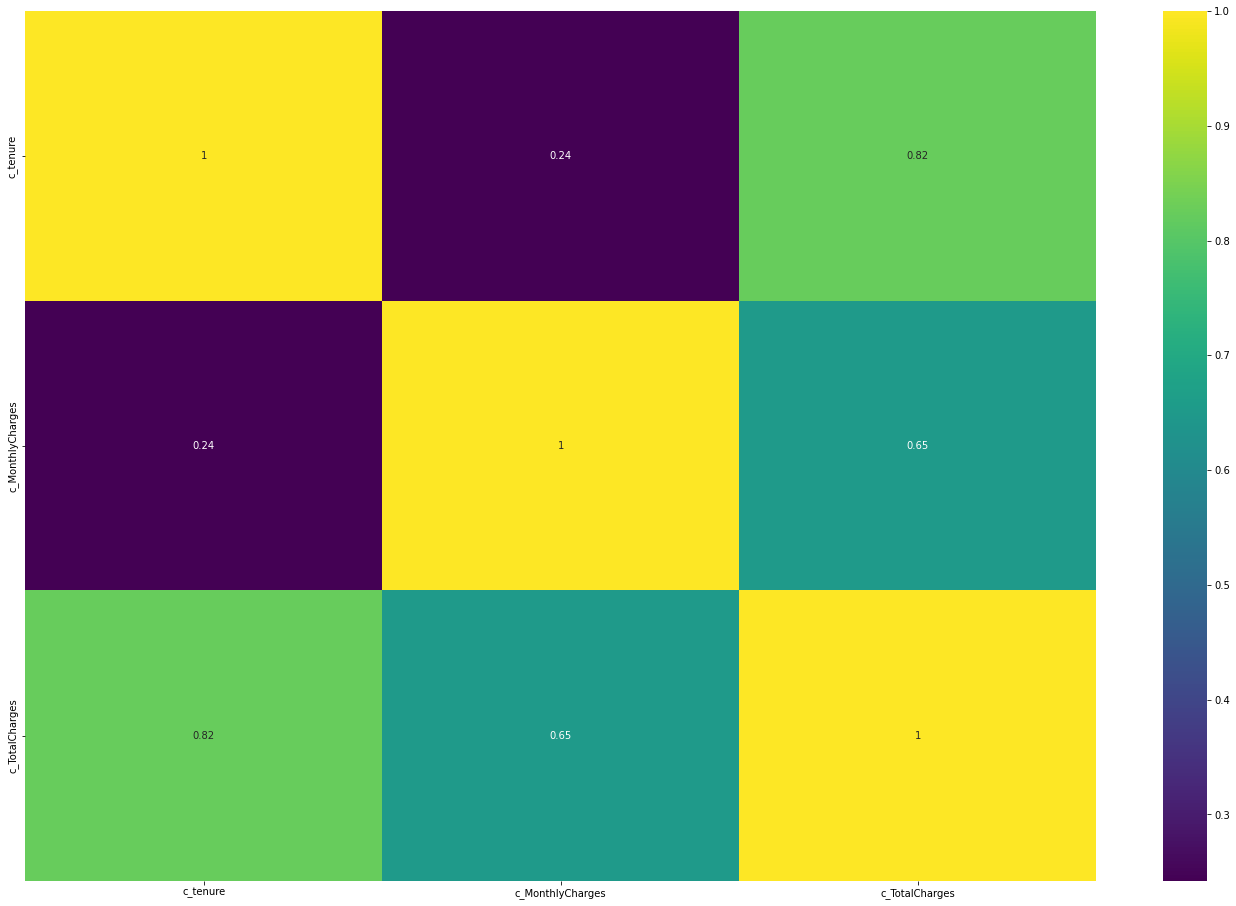

In [ ]:
plt.figure(figsize=(24, 16))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

In [ ]:
# Cambiamos todas las variables de si y no por 1 y 0
df['v_gender']=df['v_gender'].map(lambda x: 1 if x=='female' else 0)
df['v_Partner']=df['v_Partner'].map(lambda x: 1 if x=='yes' else 0)
df['v_Dependents']=df['v_Dependents'].map(lambda x: 1 if x=='yes' else 0)
df['v_PhoneService']=df['v_PhoneService'].map(lambda x: 1 if x=='yes' else 0)
df['v_OnlineSecurity']=df['v_OnlineSecurity'].map(lambda x: 1 if x=='yes' else 0)
df['v_OnlineBackup']=df['v_OnlineBackup'].map(lambda x: 1 if x=='yes' else 0)
df['v_DeviceProtection']=df['v_DeviceProtection'].map(lambda x: 1 if x=='yes' else 0)
df['v_TechSupport']=df['v_TechSupport'].map(lambda x: 1 if x=='yes' else 0)
df['v_StreamingTV']=df['v_StreamingTV'].map(lambda x: 1 if x=='yes' else 0)
df['v_StreamingMovies']=df['v_StreamingMovies'].map(lambda x: 1 if x=='yes' else 0)
df['v_PaperlessBilling']=df['v_PaperlessBilling'].map(lambda x: 1 if x=='yes' else 0)
df['v_MultipleLines']=df['v_MultipleLines'].map(lambda x: 1 if x=='yes' else 0)

In [ ]:
df = pd.get_dummies(df, columns = [ 'v_Contract','v_PaymentMethod','v_InternetService'], prefix_sep='_')

In [ ]:
# Notemos que tenemos una variable demasiado alta
X_train = X_train.drop(columns=["c_tenure"])
X_test = X_test.drop(columns=["c_tenure"])
# Se actualiza la lista de variables numericas
c_variables_new = [x for x in c_variables_new if x not in ["c_tenure"]]

# Modelado

In [ ]:
df['tgt'].replace('yes', "1", inplace=True)
df['tgt'].replace('no', "0", inplace=True)

In [ ]:
##eliminamos la variable customerID ya que no es de utilidad
df.drop(columns=["v_customerID", ],inplace=True)

#separamos las variables de la variable objetivo
X = df[[x for x in df.columns if x!='c_TotalCharges']]
y = df[['c_TotalCharges']]

In [ ]:
X

v_gender v_SeniorCitizen  v_Partner  v_Dependents  c_tenure  \
0            1               0          1             0         1   
1            0               0          0             0        34   
2            0               0          0             0         2   
3            0               0          0             0        45   
4            1               0          0             0         2   
...        ...             ...        ...           ...       ...   
6675         0               0          1             1        24   
6676         1               0          1             1        72   
6677         1               0          1             1        11   
6678         0               1          1             0         4   
6679         0               0          0             0        66   

      v_PhoneService  v_MultipleLines  v_OnlineSecurity  v_OnlineBackup  \
0                  0                0                 0               1   
1                  1                0                 1               0   
2                  1                0                 1               1   
3                  0                0                 1               0   
4                  1                0                 0               0   
...              ...              ...               ...             ...   
6675               1                1                 1               0   
6676               1                1                 0               1   
6677               0                0                 1               0   
6678               1                1                 0               0   
6679               1                0                 1               0   

      v_DeviceProtection  v_TechSupport  v_StreamingTV  v_StreamingMovies  \
0                      0              0              0                  0   
1                      1              0              0                  0   
2                      0              0              0                  0   
3                      1              1              0                  0   
4                      0              0              0                  0   
...                  ...            ...            ...                ...   
6675                   1              1              1                  1   
6676                   1              0              1                  1   
6677                   0              0              0                  0   
6678                   0              0              0                  0   
6679                   1              1              1                  1   

      v_PaperlessBilling  c_MonthlyCharges tgt  v_Contract_month to month  \
0                      1             29.85   0                          1   
1                      0             56.95   0                          0   
2                      1             53.85   1                          1   
3                      0             42.30   0                          0   
4                      1             70.70   1                          1   
...                  ...               ...  ..                        ...   
6675                   1             84.80   0                          0   
6676                   1            103.20   0                          0   
6677                   1             29.60   0                          1   
6678                   1             74.40   1                          1   
6679                   1            105.65   0                          0   

      v_Contract_one year  v_Contract_two year  \
0                       0                    0   
1                       1                    0   
2                       0                    0   
3                       1                    0   
4                       0                    0   
...                   ...                  ...   
6675                    1                    0   
6676                    1 

In [ ]:
y

c_TotalCharges
0              29.85
1            1889.50
2             108.15
3            1840.75
4             151.65
...              ...
6675         1990.50
6676         7362.90
6677          346.45
6678          306.60
6679         6844.50

[6680 rows x 1 columns]

In [ ]:
#separamos las variables de entrenamiento y prueba de nuestra base
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [ ]:
#sacamos los escaladores de las variables
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sc_X=StandardScaler()

X_train_std=sc_X.fit_transform(X_train)

X_test_std=sc_X.transform(X_test)

In [ ]:
X_train

v_gender v_SeniorCitizen  v_Partner  v_Dependents  c_tenure  \
5738         1               1          0             0         8   
1578         0               1          0             1         1   
2172         0               0          0             0         1   
1161         0               0          1             0        61   
1035         0               0          1             1         5   
...        ...             ...        ...           ...       ...   
4931         0               0          1             1        72   
3264         1               0          1             1        34   
1653         1               0          1             0        54   
2607         1               0          1             1        19   
2732         0               1          1             0        70   

      v_PhoneService  v_MultipleLines  v_OnlineSecurity  v_OnlineBackup  \
5738               1                0                 0               1   
1578               1                0                 0               0   
2172               0                0                 0               0   
1161               1                1                 1               0   
1035               1                1                 0               0   
...              ...              ...               ...             ...   
4931               1                1                 0               1   
3264               1                0                 1               1   
1653               1                0                 0               0   
2607               0                0                 0               0   
2732               1                1                 0               1   

      v_DeviceProtection  v_TechSupport  v_StreamingTV  v_StreamingMovies  \
5738                   0              0              1                  0   
1578                   1              0              0                  0   
2172                   0              0              0                  0   
1161                   1              1              0                  1   
1035                   0              1              0                  0   
...                  ...            ...            ...                ...   
4931                   1              0              1                  1   
3264                   1              0              0                  0   
1653                   0              0              0                  0   
2607                   0              0              0                  0   
2732                   1              0              1                  1   

      v_PaperlessBilling  c_MonthlyCharges tgt  v_Contract_month to month  \
5738                   1             87.10   0                          1   
1578                   1             50.15   1                          1   
2172                   1             25.15   1                          1   
1161                   0             75.35   0                          0   
1035                   1             55.70   0                          1   
...                  ...               ...  ..                        ...   
4931                   1            104.45   0                          0   
3264                   1             60.80   0                          0   
1653                   0             20.05   0                          0   
2607                   1             24.85   0                          1   
2732                   1            102.95   1                          1   

      v_Contract_one year  v_Contract_two year  \
5738                    0                    0   
1578                    0                    0   
2172                    0                    0   
1161                    0                    1   
1035                    0                    0   
...                   ...                  ...   
4931                    1                    0   
3264                    1 

## Regresion Lineal

In [ ]:
#regresion lineal
from sklearn.linear_model import LinearRegression
lr=LinearRegression()

#entrenamos el modelo en el conjunto escalados
lr.fit(X_train_std,y_train)

lr.predict(X_test_std)

array([[ 6165.78006503],
       [ 5716.78006503],
       [ 5354.78006503],
       [ 4809.78006503],
       [ -500.21993497],
       [ 6655.78006503],
       [ -371.21993497],
       [ 4828.78006503],
       [ 5099.78006503],
       [ 1904.78006503],
       [ 2308.78006503],
       [ 5396.78006503],
       [ 5921.78006503],
       [ 2995.78006503],
       [  357.78006503],
       [  613.78006503],
       [ 1631.78006503],
       [ 3129.78006503],
       [  135.78006503],
       [ 6427.78006503],
       [ 3908.78006503],
       [  409.78006503],
       [ 1264.78006503],
       [ 1294.78006503],
       [ 3375.78006503],
       [ -101.21993497],
       [ 4077.78006503],
       [ 5240.78006503],
       [ 2491.78006503],
       [ 3535.78006503],
       [ -996.21993497],
       [ 1060.78006503],
       [ -216.21993497],
       [ 2253.78006503],
       [ 4021.78006503],
       [-1113.21993497],
       [  219.78006503],
       [ 4452.78006503],
       [ -751.21993497],
       [ 4305.78006503],


In [ ]:
#calculamos las metricas para obsrvar el modelo que tan bueno fue el modelo
metricas(y_test,lr.predict(X_test_std))

El r2 score es 0.9093424070320331
El error cuadrático medio es 488151.67136482126
El error medio absoluto es 568.0544484443639


In [ ]:
#observamos la realidad con las predicciones que hizo el modelo
predicciones=y_test.copy()
predicciones['lr']=lr.predict(X_test_std)
predicciones.reset_index(drop=True,inplace=True)
predicciones

c_TotalCharges           lr
0           6856.95  6165.780065
1           6118.95  5716.780065
2           5844.65  5354.780065
3           5676.00  4809.780065
4             55.00  -500.219935
..              ...          ...
663          249.95  -202.219935
664         2331.30  2991.780065
665         1304.80  2897.780065
666         2362.10  2647.530065
667          827.05  1467.030065

[668 rows x 2 columns]

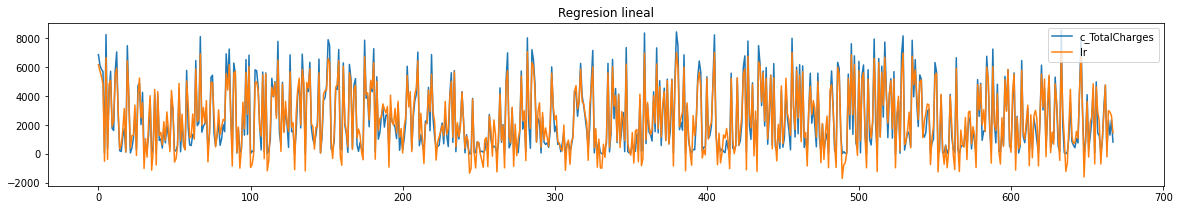

In [ ]:
#lo observamos graficamente la comparacion
predicciones[['c_TotalCharges','lr']].plot(figsize=(20,3),title="Regresion lineal")

## LASSO

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
lasso=Lasso()

In [ ]:
lasso.fit(X_train_std,y_train)

Lasso()

In [ ]:
lasso.predict(X_test_std)

array([ 6.14273432e+03,  5.70018068e+03,  5.36767076e+03,  4.84478771e+03,
       -5.02783003e+02,  6.62204037e+03, -3.00064494e+02,  4.80576451e+03,
        5.14403361e+03,  1.95150887e+03,  2.32020965e+03,  5.39263124e+03,
        5.91755385e+03,  2.99672065e+03,  3.59182790e+02,  6.36709084e+02,
        1.67833312e+03,  3.10592787e+03,  1.84843386e+02,  6.39986233e+03,
        3.91412637e+03,  4.04883851e+02,  1.29362007e+03,  1.35538038e+03,
        3.38614401e+03, -7.97171638e+01,  4.08169300e+03,  5.23654394e+03,
        2.47464639e+03,  3.52446015e+03, -1.00393172e+03,  1.04752571e+03,
       -2.27481210e+02,  2.23245999e+03,  3.99063670e+03, -1.11200092e+03,
        2.07683781e+02,  4.51645081e+03, -7.93262511e+02,  4.30466230e+03,
        1.27212495e+03,  1.52657281e+03,  6.39291711e+02,  2.23760430e+03,
        9.43075939e+02,  2.89081232e+03,  1.71710906e+03,  1.47147994e+02,
        4.35448332e+03,  3.22378216e+03, -5.41323985e+02, -3.48494860e+02,
        5.50616689e+02,  

In [ ]:
metricas(y_test,lasso.predict(X_test_std))

El r2 score es 0.909599329133143
El error cuadrático medio es 486768.2576985028
El error medio absoluto es 568.5386753125866


In [ ]:
lasso.n_features_in_

26

In [ ]:
lasso.coef_

array([ -10.87508752,    1.80476609,    4.77403062,  -17.03137581,
       1481.13371693,    9.68555926,   43.05561478,  108.87100807,
        133.11497189,  106.68352937,  100.83606107,   81.20184415,
         82.46173983,    0.        ,  906.55906327,  -71.00572008,
         15.49991678,   -0.        ,  -84.1402906 ,   -0.        ,
          6.77299578,  -26.71767944,   93.09641773,  -76.57151408,
          0.        ,   69.82583181])

In [ ]:
predicciones['lasso']=lasso.predict(X_test_std)
predicciones

c_TotalCharges           lr        lasso
0           6856.95  6165.780065  6142.734323
1           6118.95  5716.780065  5700.180680
2           5844.65  5354.780065  5367.670756
3           5676.00  4809.780065  4844.787711
4             55.00  -500.219935  -502.783003
..              ...          ...          ...
663          249.95  -202.219935  -217.485098
664         2331.30  2991.780065  2957.287425
665         1304.80  2897.780065  2899.041156
666         2362.10  2647.530065  2631.977320
667          827.05  1467.030065  1461.243972

[668 rows x 3 columns]

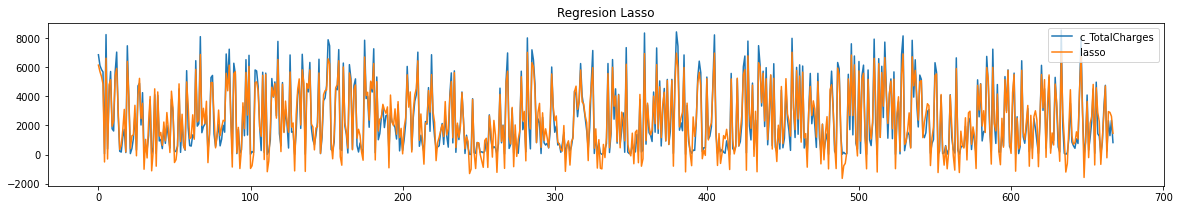

In [ ]:
predicciones[['c_TotalCharges','lasso']].plot(figsize=(20,3),title="Regresion Lasso")


## Ridge

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
ridge=Ridge()

In [ ]:
ridge.fit(X_train_std,y_train)

Ridge()

In [ ]:
ridge.predict(X_test_std)

array([[ 6.15167084e+03],
       [ 5.71030358e+03],
       [ 5.36562514e+03],
       [ 4.84700619e+03],
       [-5.08053670e+02],
       [ 6.63667690e+03],
       [-3.04522233e+02],
       [ 4.80825806e+03],
       [ 5.13927361e+03],
       [ 1.94710738e+03],
       [ 2.31355344e+03],
       [ 5.39453105e+03],
       [ 5.90623246e+03],
       [ 2.99565682e+03],
       [ 3.55493846e+02],
       [ 6.33004170e+02],
       [ 1.65900361e+03],
       [ 3.10279414e+03],
       [ 1.83967851e+02],
       [ 6.40892610e+03],
       [ 3.91655270e+03],
       [ 4.07956211e+02],
       [ 1.29408018e+03],
       [ 1.34416043e+03],
       [ 3.38054793e+03],
       [-8.25344568e+01],
       [ 4.09322995e+03],
       [ 5.23890381e+03],
       [ 2.48652872e+03],
       [ 3.51719687e+03],
       [-9.92830714e+02],
       [ 1.04697189e+03],
       [-2.36338819e+02],
       [ 2.23540705e+03],
       [ 3.99663668e+03],
       [-1.10285980e+03],
       [ 2.07742544e+02],
       [ 4.51466120e+03],
       [-7.7

In [ ]:
metricas(y_test,ridge.predict(X_test_std))

El r2 score es 0.909470004499765
El error cuadrático medio es 487464.6145492128
El error medio absoluto es 568.6142768012246


In [ ]:
predicciones['ridge']=ridge.predict(X_test_std)

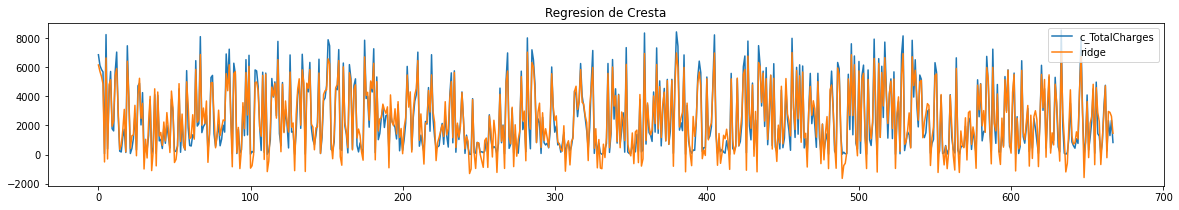

In [ ]:
predicciones[['c_TotalCharges','ridge']].plot(figsize=(20,3),title="Regresion de Cresta")

## Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet


In [ ]:
elastic=ElasticNet(alpha=.5)

In [ ]:
elastic.fit(X_train_std,y_train)

ElasticNet(alpha=0.5)

In [ ]:
elastic.predict(X_test_std)

array([ 5.40414767e+03,  5.27065661e+03,  4.84579543e+03,  4.61415131e+03,
       -2.69855543e+02,  6.41065381e+03,  1.25494824e+02,  4.31270358e+03,
        5.27666659e+03,  2.04502320e+03,  1.82075486e+03,  5.03764733e+03,
        5.81309748e+03,  2.76361531e+03,  8.69299807e+02,  8.99297075e+02,
        2.33618611e+03,  2.85824371e+03,  5.81844273e+02,  6.02237585e+03,
        3.01445030e+03,  4.71207795e+02,  1.34062085e+03,  1.57204066e+03,
        3.53617319e+03,  2.04590489e+02,  3.42676692e+03,  5.58495190e+03,
        2.14742543e+03,  2.90444844e+03, -4.68305347e+02,  9.16798650e+02,
        3.02994171e+02,  2.04145106e+03,  3.81062957e+03, -6.61057500e+02,
        6.16654656e+02,  4.80115790e+03, -5.28524702e+02,  4.10804725e+03,
        1.23837935e+03,  1.62712100e+03,  7.32303708e+02,  2.05254413e+03,
        1.23261821e+03,  3.04681050e+03,  2.04601615e+03,  5.36146651e+02,
        3.89813942e+03,  3.34598325e+03, -2.25014827e+02, -4.11026090e+02,
        7.87128798e+02,  

In [ ]:
metricas(y_test,elastic.predict(X_test_std))

El r2 score es 0.8859556983744805
El error cuadrático medio es 614078.9163440724
El error medio absoluto es 646.7000604100189


In [ ]:
predicciones['elastic']=elastic.predict(X_test_std)

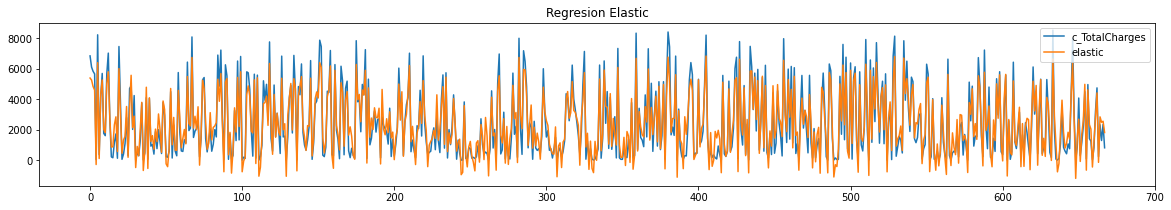

In [ ]:
predicciones[['c_TotalCharges','elastic']].plot(figsize=(20,3),title="Regresion Elastic")


## LARS  

In [ ]:
from sklearn.linear_model import Lars

In [ ]:
lars=Lars()

In [ ]:
lars.fit(X_train_std,y_train)

Lars()

In [ ]:
lars.predict(X_test_std)

array([ 6.20374616e+03,  5.74155866e+03,  5.29579304e+03,  4.88535554e+03,
       -5.05410090e+02,  6.74324616e+03, -3.67441340e+02,  4.85799616e+03,
        5.08988679e+03,  1.80541804e+03,  2.29318366e+03,  5.33862116e+03,
        5.77382429e+03,  2.98690241e+03,  3.18402410e+02,  6.23433660e+02,
        1.39896491e+03,  3.11421491e+03,  1.68855535e+02,  6.47038679e+03,
        3.95371491e+03,  4.67886785e+02,  1.28071491e+03,  1.20688679e+03,
        3.23499616e+03, -1.33597590e+02,  4.24263679e+03,  5.23196491e+03,
        2.62558991e+03,  3.49616804e+03, -8.94128840e+02,  1.09285554e+03,
       -3.22441340e+02,  2.30766804e+03,  4.04046491e+03, -1.08197259e+03,
        1.67527410e+02,  4.25144929e+03, -6.82019465e+02,  4.27340241e+03,
        1.39048054e+03,  1.49024616e+03,  6.37183660e+02,  2.18083991e+03,
        8.52824285e+02,  2.72466804e+03,  1.48568366e+03,  9.87149103e+01,
        4.37702741e+03,  3.14751179e+03, -7.18488215e+02, -2.60644465e+02,
        4.82121160e+02,  

In [ ]:
metricas(y_test,lars.predict(X_test_std))

El r2 score es 0.9053376028780877
El error cuadrático medio es 509715.7982871845
El error medio absoluto es 578.5760530861675


In [ ]:
predicciones['lars']=lars.predict(X_test_std)

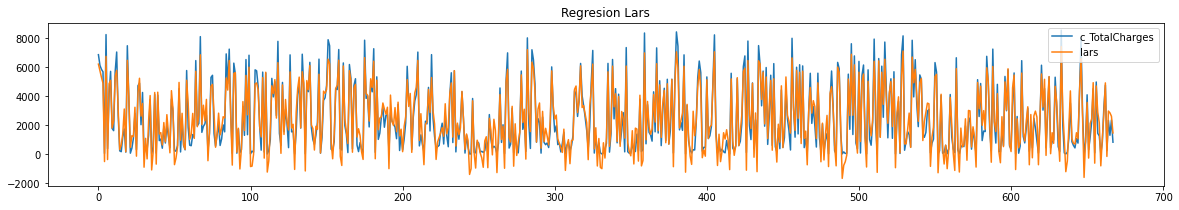

In [ ]:
predicciones[['c_TotalCharges','lars']].plot(figsize=(20,3),title="Regresion Lars")

## Regresión Bayesiana

In [ ]:
from sklearn.linear_model import BayesianRidge

In [ ]:
bayesian_ridge=BayesianRidge()

In [ ]:
y_train

c_TotalCharges
5738          713.60
1578           50.15
2172           25.15
1161         4729.30
1035          259.40
...              ...
4931         7459.00
3264         2042.05
1653         1102.40
2607          434.80
2732         7101.50

[6012 rows x 1 columns]

In [ ]:
bayesian_ridge.fit(X_train_std,y_train["c_TotalCharges"])

BayesianRidge()

In [ ]:
bayesian_ridge.predict(X_test_std)

array([ 6144.72243168,  5712.1210194 ,  5365.34544424,  4841.21547838,
        -508.22187595,  6629.08154061,  -298.36895025,  4803.38814691,
        5140.78297055,  1955.84818374,  2311.2348292 ,  5403.60888911,
        5915.57114497,  2994.49492993,   358.71007854,   633.89256597,
        1677.28795721,  3101.91537078,   184.27967911,  6402.22880779,
        3916.45890554,   403.37825918,  1294.85289706,  1352.50544455,
        3388.32833707,   -77.4651098 ,  4081.5186277 ,  5239.83213908,
        2478.61155304,  3519.04015592,  -997.51778727,  1043.76014107,
        -230.49667117,  2230.29145428,  3996.48258534, -1101.23992354,
         210.22783228,  4530.04331459,  -782.59090807,  4297.22964924,
        1265.46220343,  1522.37727223,   631.76277201,  2232.56670285,
         935.89917651,  2894.86732406,  1721.85951685,   143.9000031 ,
        4354.39964909,  3228.78941189,  -532.04489307,  -339.23998212,
         550.31705468,  4860.55706181,   894.80965177,  2779.89018717,
      

In [ ]:
metricas(y_test,bayesian_ridge.predict(X_test_std))

El r2 score es 0.9095817003615375
El error cuadrático medio es 486863.1809591105
El error medio absoluto es 568.706610287554


In [ ]:
predicciones['bayesiana']=bayesian_ridge.predict(X_test_std)

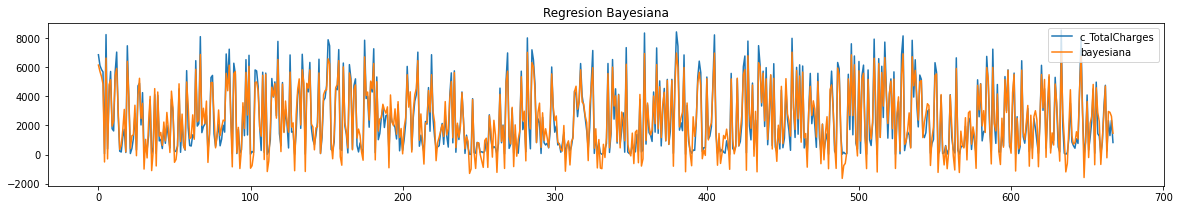

In [ ]:
predicciones[['c_TotalCharges','bayesiana']].plot(figsize=(20,3),title="Regresion Bayesiana")

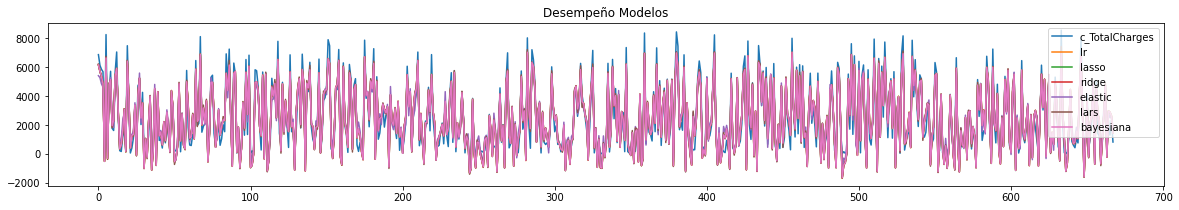

In [ ]:
predicciones.plot(figsize=(20,3),title="Desempeño Modelos")

In [ ]:
lr

LinearRegression()

In [ ]:
pd.to_pickle(lr,'Modelo_rl.pkl')

In [ ]:
modelo=pd.read_pickle('Modelo_rl.pkl')

In [ ]:
modelo.predict(X_train)

array([[5.93806159e+15],
       [4.96395114e+15],
       [6.16413198e+15],
       ...,
       [5.50224838e+15],
       [4.96395114e+15],
       [5.93806159e+15]])

In [ ]:
pd.to_pickle(sc_X,'standard_insurance.pkl')